# Twitter Sentiment Analysis

### Introduction
Twitter sentiment analysis is a natural language processing (NLP) task that involves analyzing and determining the sentiment expressed in a given tweet. Sentiment analysis has a wide range of applications, including understanding public opinion, brand monitoring, and market research. Preprocessing the data is a crucial step in any NLP project, as it helps clean and structure the raw text data, making it suitable for machine learning algorithms.

### Importance of Data Preprocessing
Data preprocessing is a fundamental step in NLP projects because raw text data from sources like social media can be messy, noisy, and unstructured. Preprocessing helps transform this data into a format that can be effectively used by machine learning models. It involves tasks such as removing irrelevant information, cleaning up special characters, tokenizing text, and more. Proper preprocessing ensures that the model receives high-quality input, leading to improved performance and accurate results.

### Data Preprocessing for Twitter Sentiment Analysis

1. Data Collection:
In this step, we will collect tweets related to a specific topic or query using the Twitter API or by using pre-collected datasets. Each tweet contains the actual text content, user information, timestamps, and other metadata.

2. Cleaning and Noise Reduction:
Raw text data often contains unnecessary information, such as hyperlinks, mentions, special characters, and emojis. These can negatively impact the performance of your sentiment analysis model. Use regular expressions to remove hyperlinks, mentions, and special characters, and consider removing or encoding emojis.

3. Lowercasing:
Converting all text to lowercase. This helps in standardizing the text and ensures that the model treats words with different capitalizations as the same.

4. Tokenization:
Tokenization involves splitting the text into individual words or tokens. TWe will be using nlkt library for tokenization. Tokenization is a critical step as it prepares the text for further processing.

5. Stopword Removal:
Stopwords are common words like "and," "the," "is," etc. that don't carry significant meaning and can be safely removed from the text. Libraries like nltk provide lists of stopwords.

5. Lemmatization or Stemming:
Lemmatization reduces words to their base or dictionary form (lemma), while stemming truncates words to their root form. This step reduces words to their basic meanings, helping the model generalize better.

7. Data Transformation:
Transform the preprocessed text data into numerical representations that can be fed into machine learning algorithms. This can be achieved using techniques like word embeddings or pretrained language models.

![nlp-pipeline](https://media.licdn.com/dms/image/C4D12AQHsdEIHnH7KNQ/article-cover_image-shrink_600_2000/0/1566722923152?e=2147483647&v=beta&t=YsmFCdp6hlGK7-8KYTadb6LXwKrnhBrmLlRt-RNfjIg)

#### Importing Libraries and Reading CSV file

In [1]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud

import nltk
import re
import string

from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from keras.preprocessing.text import Tokenizer

nltk.download("stopwords")

import tweepy

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Reading CSV File:
df=pd.read_csv(r"C:\Users\LENOVO\Downloads\Tweets.csv")
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


#### Information of the Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

#### Data Pre-Processing:

In [5]:
df= df.dropna()

In [6]:
df=df.rename(columns={'text': 'tweets','sentiment': 'label'})
df.head()

,textID,tweets,selected_text,label
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


We drop rows that contain missing values using the dropna() function. 
Next, we rename the columns 'text' and 'sentiment' to 'tweets' and 'label', respectively, to enhance readability.

In [7]:
tweets=df['tweets']

We start by extracting the 'tweets' column from the dataframe to work specifically with the text data.

In [8]:
def preprocess_text(text):
    text =text.lower() #Converting to lower case
    text = re.sub(r"http\S+", "", text)  #Excluding hyperlinks
    text = re.sub(r"www\.\S+", " ", text)  #Excluding links starting with 'www'
    text = re.sub(r"@\w+", " ", text)  #Excluding tagged data
    text = re.sub(r"[^A-Za-z\s]", " ", text)  #Excluding non-alphabetical characters except whitespace
    return text.strip()

cleaned_tweets=[preprocess_text(tweet) for tweet in tweets]

The preprocess_text() function is defined to handle the cleaning process. Within this function:

1. text.lower(): Converts the text to lowercase to ensure uniformity and reduce the complexity of the analysis.
2. re.sub(r"http\S+", "", text): Removes hyperlinks (URLs) from the text data using regular expressions.
3. re.sub(r"www\.\S+", " ", text): Removes links starting with 'www'.
4. re.sub(r"@\w+", " ", text): Removes tagged data (mentions) using regular expressions.
5. re.sub(r"[^A-Za-z\s]", " ", text): Removes non-alphabetical characters except whitespace using regular expressions.
6. .strip(): Removes any leading or trailing whitespace from the cleaned text.

The list comprehension cleaned_tweets applies the preprocess_text() function to each tweet in the 'tweets' column, resulting in a list of cleaned text data.

We will be now focusing on two important preprocessing steps: 

**Stopword Removal and Tokenization.** 

In [9]:
stop_words=set(stopwords.words('english'))
tokenizer=TweetTokenizer()

print("List of Stop Words that will be removed :\n",stop_words,"\n\n")

List of Stop Words that will be removed :
 {'m', 'during', 'over', 'why', 'there', 'these', 'herself', 'wouldn', 'once', "couldn't", 'themselves', 'some', 'only', 'such', 'your', 'yours', 'too', 'ours', 'whom', 'be', 'do', 'no', "haven't", 'were', 'has', 'not', 'should', 'ain', 'from', "needn't", "shan't", 'about', 'shan', 'own', 'haven', 'myself', 's', 'against', "weren't", 'its', 'as', 'any', 'are', 'our', 'through', 'the', 'now', 'itself', 'those', 'on', "you've", 'yourself', 'of', 'where', "shouldn't", 'and', 'because', 'when', 'or', 'can', "you'll", 'out', "wouldn't", 'what', 'aren', 'but', "wasn't", 'couldn', 'she', 'a', 'very', 'does', 'hadn', 'mightn', 'so', 'am', 'to', 've', 'shouldn', 'this', "hadn't", 'more', 't', 'under', "won't", 'you', 'is', 'being', 'until', 'most', 'few', 'will', 'have', 're', 'again', 'an', 'isn', "it's", 'both', 'in', 'between', 'their', 'don', 'after', 'each', 'hasn', 'who', 'weren', 'his', 'was', "hasn't", "you'd", 'needn', 'd', 'won', "should've", 

In [10]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word not in stop_words]
    return tokens

preprocessed_tweets = [preprocess(tweet) for tweet in cleaned_tweets]

In [11]:
preprocessed_tweets_str = [" ".join(tokens) for tokens in preprocessed_tweets]
preprocessed_tweets

[['responded', 'going'],
 ['sooo', 'sad', 'miss', 'san', 'diego'],
 ['bos', 'bullying'],
 ['interview', 'leave', 'alone'],
 ['son', 'put', 'release', 'already', 'bought'],
 ['shameless', 'plugging', 'best', 'ranger', 'forum', 'earth'],
 ['feeding', 'baby', 'fun', 'smile', 'coo'],
 ['soooo', 'high'],
 [],
 ['journey', 'wow', 'u', 'became', 'cooler', 'hehe', 'possible'],
 ['much',
  'love',
  'hopeful',
  'reckon',
  'chance',
  'minimal',
  'p',
  'never',
  'gonna',
  'get',
  'cake',
  'stuff'],
 ['really', 'really', 'like', 'song', 'love', 'story', 'taylor', 'swift'],
 ['sharpie', 'running', 'dangerously', 'low', 'ink'],
 ['want', 'go', 'music', 'tonight', 'lost', 'voice'],
 ['test', 'test', 'lg', 'env'],
 ['uh', 'oh', 'sunburned'],
 ['ok', 'trying', 'plot', 'alternative', 'speak', 'sigh'],
 ['sick',
  'past',
  'day',
  'thus',
  'hair',
  'look',
  'wierd',
  'didnt',
  'hat',
  'would',
  'look'],
 ['back', 'home', 'gonna', 'miss', 'every', 'one'],
 ['he'],
 ['oh', 'marly', 'sorry

In the Stopword Removal, english stopwords are loaded using NLTK's stopwords.words('english'). Tokenization is performed using the TweetTokenizer to split text into tokens. A list of stopwords that will be removed is printed for reference.

Next we will perform Lemmatization. Lemmatization is the process of reducing words to their base or root form, usually with the intention of improving text analysis and natural language understanding. 
For example, lemmatizing "running" would result in "run"
The WordNetLemmatizer from NLTK is used for lemmatization. The preprocess function lemmatizes tokens while excluding stopwords.

Our preprocessed_tweets is ready for modelling process.

In [12]:
df['preprocessed_tweets'] = preprocessed_tweets

def polarity(text):
    return TextBlob(text).sentiment.polarity

polarities = [polarity(' '.join(tokens)) for tokens in preprocessed_tweets]
df['polarity'] = polarities
df[['preprocessed_tweets', 'polarity']]

,preprocessed_tweets,polarity
0,"[responded, going]",0.000000
1,"[sooo, sad, miss, san, diego]",-0.500000
2,"[bos, bullying]",0.000000
3,"[interview, leave, alone]",0.000000
4,"[son, put, release, already, bought]",0.000000
...,...,...
27476,"[wish, could, come, see, u, denver, husband, l...",0.000000
27477,"[wondered, rake, client, made, clear, net, for...",0.184091
27478,"[yay, good, enjoy, break, probably, need, hect...",0.550000
27479,[worth],0.300000


The function 'polarity' is defined to calculate the sentiment polarity of a given text using TextBlob.

Polarity, in the context of sentiment analysis, refers to a measure of the sentiment expressed in a piece of text. It indicates whether the text conveys a positive, negative, or neutral sentiment. Polarity is here represented as a numerical value within a specific range, often ranging from -1 (most negative) to 1 (most positive).

For each preprocessed tweet, the 'polarity' function is applied to the joined tokens of the tweet. The calculated polarities are stored in the 'polarities' list. The 'polarities' list is added to our 'df' as a new column named 'polarity'.

#### Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

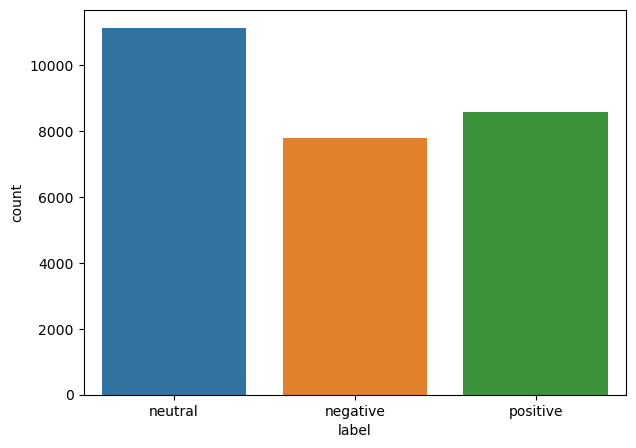

In [13]:
fig=plt.figure(figsize=(7,5))
sns.countplot(x='label',data=df)

From the plot, we can see that the "neutral" sentiment label has the highest count, followed by the "positive" label and then the "negative" label. This distribution suggests that the majority of the text data in your dataset is labeled as "neutral," with around 10,000 instances. The "positive" and "negative" sentiment labels have slightly fewer instances, with around 8,000 and 7,500 instances respectively.

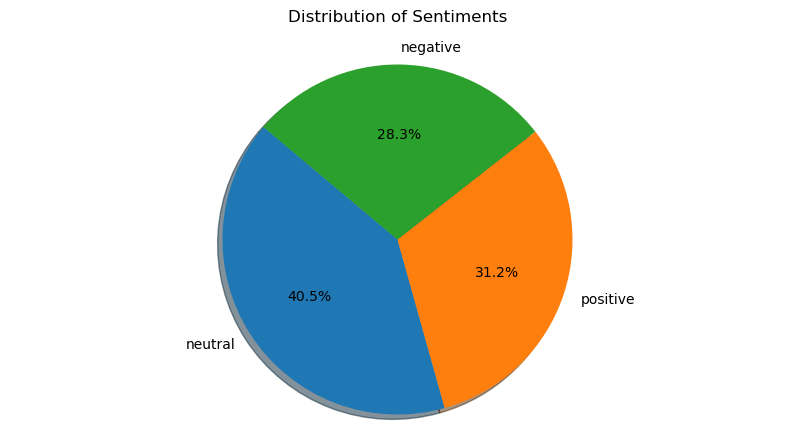

In [14]:
fig,ax=plt.subplots(figsize=(10,5))
labels=df['label'].value_counts().index
sizes=df['label'].value_counts().values

plt.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True,startangle=140)
ax.axis("equal")
plt.title("Distribution of Sentiments\n")
plt.show()

Each slice of the pie represents a sentiment label ("neutral," "negative," and "positive"), and the size of the slice corresponds to the percentage of instances with that sentiment label in the dataset.
1. Approximately 40.5% of the instances in your dataset are labeled as "neutral."
2. Around 31.2% of the instances are labeled as "negative."
3. About 28.3% of the instances are labeled as "positive."

In [15]:
#Visualaizing Top 10 Positive Sentiments
positive_tweets=df[df['label']=='positive'].sort_values('polarity',ascending=False)
positive_tweets.head(10)

,textID,tweets,selected_text,label,preprocessed_tweets,polarity
21064,454666ed2d,"Awesome, congrats on completing it! (I can`t ...","Awesome,",positive,"[awesome, congrats, completing, believe, cycle...",1.0
6646,9a28a236b8,Twitter is officially the BEST way to advertis...,officially the BEST way,positive,"[twitter, officially, best, way, advertise, so...",1.0
16630,19bdfd834b,did you get them from california vintage? aha...,BEST,positive,"[get, california, vintage, ahahah, best, dress...",1.0
19772,42361142b5,Gary Just tried the Ommegang Chocolate Indulge...,Best I can...,positive,"[gary, tried, ommegang, chocolate, indulgence,...",1.0
5562,90fffbe4ef,The Skimchamp Taxi Service! best in the land!,best in the land!,positive,"[skimchamp, taxi, service, best, land]",1.0
19826,c64c289b4c,had the best weekend,the best weekend,positive,"[best, weekend]",1.0
2587,ae2282aefe,NKOTB world is the best place to be,best,positive,"[nkotb, world, best, place]",1.0
4699,f2262dc310,apple fritters are like the perfect after food...,the perfect after food...,positive,"[apple, fritter, like, perfect, food, think]",1.0
481,9c2b1313af,Why kiss the feet of the people who kick you w...,best,positive,"[kiss, foot, people, kick, anything, want, mor...",1.0
22286,55fce48132,that movie is awesome!,awesome!,positive,"[movie, awesome]",1.0


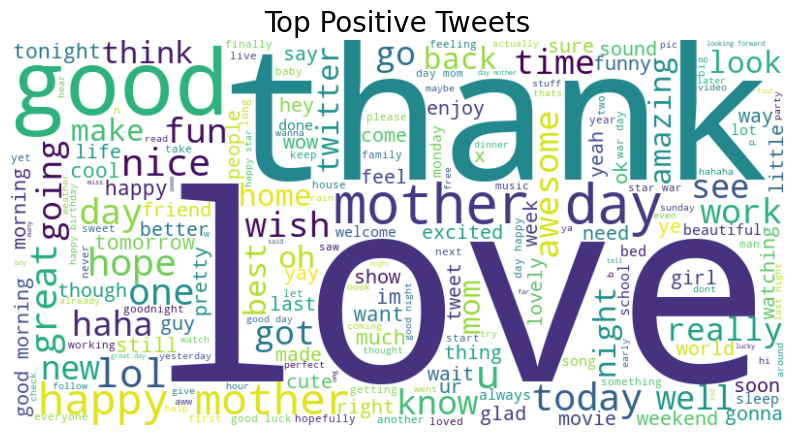

In [16]:
positive_words=' '.join([word for tweet in positive_tweets['preprocessed_tweets']for word in tweet])
wordcloud=WordCloud(width=800,height=400,background_color='white').generate(positive_words)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Top Positive Tweets",fontsize=20)
plt.show()

Above we have sorted the first 10 'positive' labels according to their polarity score in descending order and then with the help of WordCloud library we have generated a image containing most frequently occurring words from the top 10 positive sentiment tweets.

Some of the frequent words used were: thank, love, good, mother, day, nice, happy

In [17]:
#Visualaizing Top 10 Negative Sentiments
negative_tweets=df[df['label']=='negative'].sort_values('polarity',ascending=False)
negative_tweets.head(10)

,textID,tweets,selected_text,label,preprocessed_tweets,polarity
5743,b30b458b91,"wanna b marie antoinette, cos she had perfect ...",Crappy day,negative,"[wanna, b, marie, antoinette, co, perfect, hai...",1.0
10810,a7d4758b6b,"just nothing perfect in life, darn it!","just nothing perfect in life, darn it!",negative,"[nothing, perfect, life, darn]",1.0
975,9b81e91703,Please read my blog http://amandallynn.blogspo...,I`m not having the best day,negative,"[please, read, blog, best, day]",1.0
17795,5a552d5214,"Spyed Princess Anne today, and listented to al...",sucks,negative,"[spyed, princess, anne, today, listented, frie...",1.0
6955,18699f7f9b,I am hungry already. Not impressed! And everyb...,Not impressed!,negative,"[hungry, already, impressed, everybody, gone, ...",1.0
19060,ac29f09cc7,My best mate found out that I am moving. She d...,doesn`t understand,negative,"[best, mate, found, moving, understand, wanna,...",1.0
1400,1ce6042e00,"I dont like seeing my best friend cry, it brea...",it breaks my heart,negative,"[dont, like, seeing, best, friend, cry, break,...",1.0
21893,eda8f2cf40,it`s not sooo noticable it depends on how you...,d isn`t perfect,negative,"[sooo, noticable, depends, look, know, ipod, p...",1.0
5055,fa2f5557ac,_perfect I`m trying to self learn photoshop bu...,it`s not going so well!,negative,"[perfect, trying, self, learn, photoshop, goin...",1.0
24304,b883efa1a7,depressed; my best friends pissed @ me,depressed;,negative,"[depressed, best, friend, pissed]",1.0


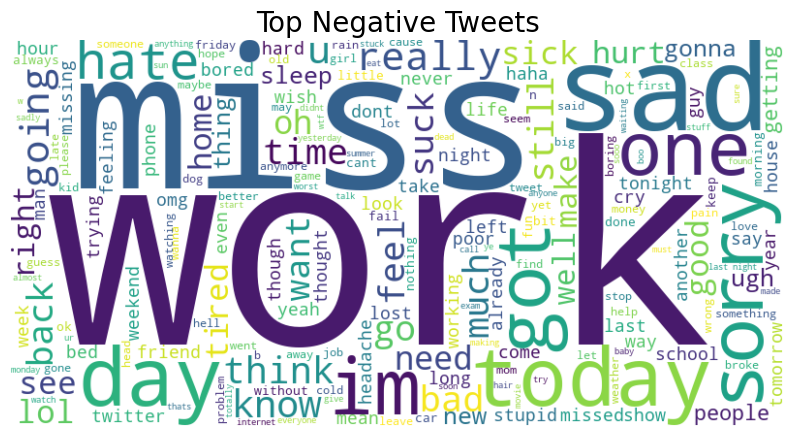

In [18]:
negative_words=' '.join([word for tweet in negative_tweets['preprocessed_tweets']for word in tweet])
wordcloud=WordCloud(width=800,height=400,background_color='white').generate(negative_words)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Top Negative Tweets",fontsize=20)
plt.show()

As observed above, the top Negative words are : miss, work, sad, hate, today, sorry, etc

In [19]:
#Visualaizing Top 10 Neutral Sentiments
neutral_tweets=df[df['label']=='neutral'].sort_values('polarity',ascending=False)
neutral_tweets.head(10)

,textID,tweets,selected_text,label,preprocessed_tweets,polarity
16581,3bf3c20da4,I was talking with my best friend ï¿½ureo abou...,I was talking with my best friend ï¿½ureo abou...,neutral,"[talking, best, friend, ureo, phone, rio, de, ...",1.0
8448,58030178a2,"she was wonderful, did not get to meet her th...","she was wonderful, did not get to meet her though",neutral,"[wonderful, get, meet, though]",1.0
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,"[shameless, plugging, best, ranger, forum, earth]",1.0
5391,e2ae8ec389,My best friend is in vegas without me,My best friend is in vegas without me,neutral,"[best, friend, vega, without]",1.0
15398,8388470ea9,I`m on mobile web and it won`t let me it loo...,I`m on mobile web and it won`t let me it look...,neutral,"[mobile, web, let, look, awesome, though, one,...",1.0
17523,a1f3adf7ea,Talking to my best mate and my boyfriend on msn,Talking to my best mate and my boyfriend on msn,neutral,"[talking, best, mate, boyfriend, msn]",1.0
27004,57e8b90fc7,Maybe because you got in 4 hours ago from an ...,Maybe because you got in 4 hours ago from an a...,neutral,"[maybe, got, hour, ago, awesome, night, nah]",1.0
9963,fe56a163b9,Isn`t he awesome?? There are tons more coming...,"Isn`t he awesome?? There are tons more coming,...",neutral,"[awesome, ton, coming, one, three, location]",1.0
24882,3e61dc8b4e,OMJ! J.O.N.A.S. is the best tv show EVER! ?,OMJ! J.O.N.A.S. is the best tv show EVER! ?,neutral,"[omj, j, n, best, tv, show, ever]",1.0
4969,d5b83f848c,of couuuurse fika i`ll pray thes best for yo...,of couuuurse fika i`ll pray thes best for you...,neutral,"[couuuurse, fika, pray, thes, best]",1.0


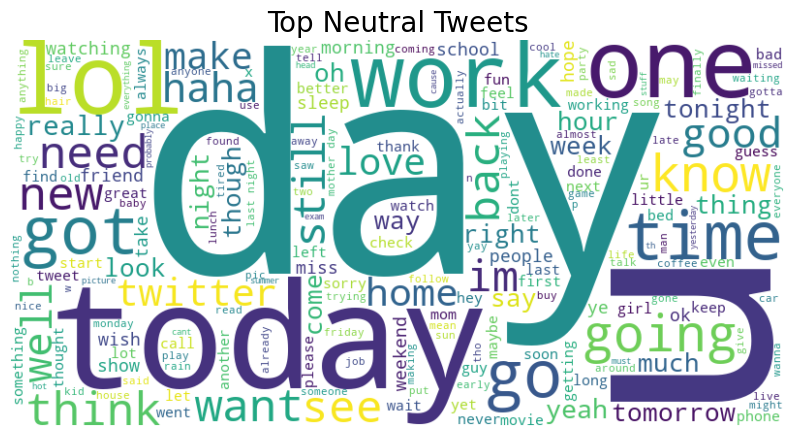

In [20]:
neutral_words=' '.join([word for tweet in neutral_tweets['preprocessed_tweets']for word in tweet])
wordcloud=WordCloud(width=800,height=400,background_color='white').generate(neutral_words)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Top Neutral Tweets",fontsize=20)
plt.show()

Most used Neutral words in our dataset is: day, u, one, time, today, lol, work, new, etc

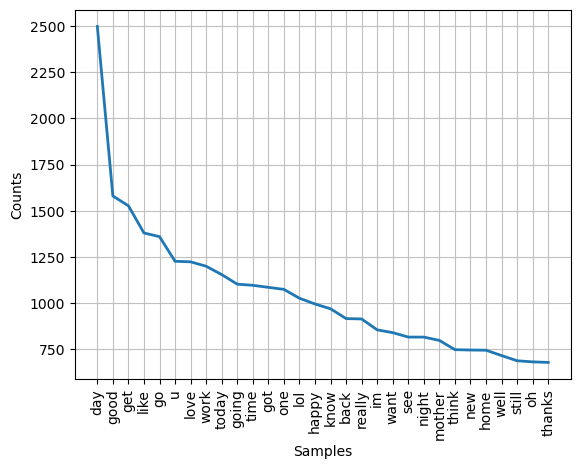

<Axes: xlabel='Samples', ylabel='Counts'>

In [21]:
#Most Common Words:
words=[token for tweet_tokens in preprocessed_tweets for token in tweet_tokens]
freq=FreqDist(words)
freq.plot(30,cumulative=False)

The above code goes through all our tweets and exacts the most common words used with their frequency.

In [22]:
#Top 20 significanr Bigram Collocations:
bigram=BigramAssocMeasures()
finder=BigramCollocationFinder.from_words(words)
finder.nbest(bigram.pmi, 20)

[('aaaagh', 'aircon'),
 ('aaaaiieee', 'squeak'),
 ('aannndd', 'psyillium'),
 ('aapko', 'sehat'),
 ('abba', 'canalway'),
 ('aber', 'dire'),
 ('abuelo', 'aguadilla'),
 ('acara', 'menarik'),
 ('accelerated', 'atom'),
 ('accessibility', 'bitv'),
 ('accessory', 'livescribe'),
 ('accompanied', 'glis'),
 ('accordion', 'thief'),
 ('aceness', 'extreme'),
 ('acknowledge', 'inevitable'),
 ('acquiring', 'centos'),
 ('acsm', 'unfathomable'),
 ('acute', 'mumps'),
 ('adaptation', 'interior'),
 ('adica', 'puricel')]

The above code is used to find the top 20 significant bigram collocations in the words list based on their PMI scores. These collocations represent pairs of words that frequently appear together and have a strong association in the given text data.

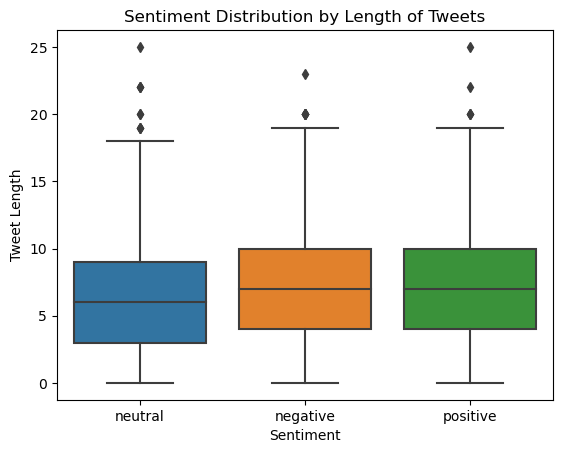

In [23]:
#Sentiment Distribution by Length of Tweets:
df['tweet_length']=df['preprocessed_tweets'].apply(lambda x:len(' '.join(x).split()))
sns.boxplot(x='label',y='tweet_length',data=df)
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length")
plt.title("Sentiment Distribution by Length of Tweets")
plt.show()

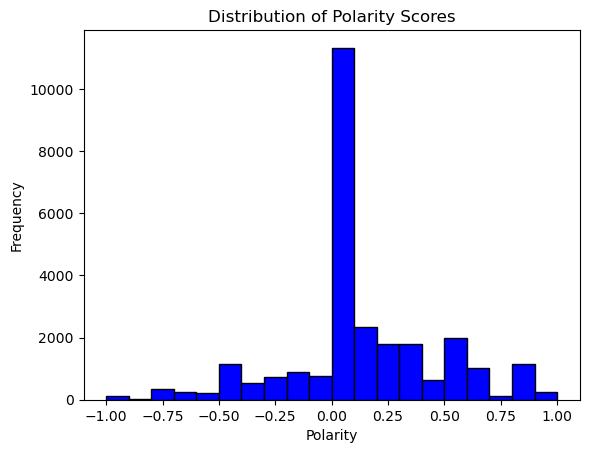

In [24]:
plt.hist(df['polarity'],bins=20,color='blue',edgecolor='black')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Polarity Scores')
plt.show()

Most of the tweets have a polarity score around 0, which indicates a neutral sentiment. These tweets may contain content that is factual or informative without expressing strong positive or negative feelings.

The number of tweets with positive polarity scores (greater than 0) is higher than the number of tweets with negative polarity scores (less than 0). This suggests that the dataset contains more tweets that express positive sentiments.

The higher number of neutral sentiment tweets could be due to various reasons. It might include tweets that are informational, contain statements of fact, or those that are expressing sentiments that are not strongly positive or negative.

The higher number of positive sentiment tweets might indicate that people tend to share content that is more positive in nature. This could be related to the topics discussed, trends, or general user behavior on social media platforms.

In [25]:
map_dict={
    'neutral':0,
    'positive':1,
    'negative':2,
}
df['label']=df['label'].map(map_dict)
df['label'].value_counts()

0    11117
1     8582
2     7781
Name: label, dtype: int64

This code maps the sentiment labels in the DataFrame to numerical values based on the provided mapping dictionary and then displays the count of each sentiment label in the dataset.